In [31]:

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [32]:
df_commodity = pd.read_csv("commodity_bryan.csv",parse_dates=["Date"], index_col="Date", encoding="latin-1")

df_commodity.head()

,0BILL_TYPE___T,0FISCYEAR,0DIVISION___T,Transactoin State,Material Level 2,Material Level 3,Material Group,Material Grade,Plant Nbr,Ship To City,Ship To County,Ship To State,Ship To Region,Ship To Country,Cal_Quarter_text,Fiscal_Year_Period_Text,Product ID,Mill_Amount_in_SC,Qty_in_Conv_Vol,ASP
Date,,,,,,,,,,,,,,,,,,,,
2017-06-30,DOMESTIC INVOICE,2017,OSB,Finished Product,COMMODITY,OSB TN 250,OSB TN 250,A,1321.0,COLORADO SPRINGS,EL PASO,Colorado,WEST,US,2017.Q2,2017.06,31113,11192.38,37,302.50
2015-01-15,CANCELLATION INVOICE,2015,OSB,Finished Product,COMMODITY,OSB Commodity,OSB Commodity,A,1030.0,OSHKOSH,WINNEBAGO,Wisconsin,NORTH CENTRAL,US,2015.Q1,2015.01,591,-4525.88,-26,174.07
2016-06-21,DOMESTIC INVOICE,2016,OSB,Finished Product,COMMODITY,OSB Commodity,OSB Commodity,A,1010.0,MADISON,DAVIDSON,Tennessee,SOUTHEAST,US,2016.Q2,2016.06,39970,7136.35,36,198.23
2014-08-01,CANCELLATION INVOICE,2014,OSB,Finished Product,COMMODITY,OSB Commodity,OSB Commodity,A,1710.0,BEAUMONT,RIVERSIDE,California,NATIONAL,US,2014.Q3,2014.08,22485,-89040.00,-392,227.14
2018-01-25,DOMESTIC INVOICE,2018,OSB,Finished Product,COMMODITY,OSB TN 250,OSB TN 250,A,1030.0,DULUTH,SAINT LOUIS,Minnesota,NATIONAL,US,2018.Q1,2018.01,22491,2524.14,11,229.47


In [33]:
df_commodity.columns

Index(['0BILL_TYPE___T', '0FISCYEAR', '0DIVISION___T', 'Transactoin State',
       'Material Level 2', 'Material Level 3', 'Material Group',
       'Material Grade', 'Plant Nbr', 'Ship To City', 'Ship To County',
       'Ship To State', 'Ship To Region', 'Ship To Country',
       'Cal_Quarter_text', 'Fiscal_Year_Period_Text', 'Product ID',
       'Mill_Amount_in_SC', 'Qty_in_Conv_Vol', 'ASP'],
      dtype='object')

In [34]:
df_commodity = df_commodity[["ASP"]]
df_commodity.head()

,ASP
Date,
2017-06-30,302.50
2015-01-15,174.07
2016-06-21,198.23
2014-08-01,227.14
2018-01-25,229.47


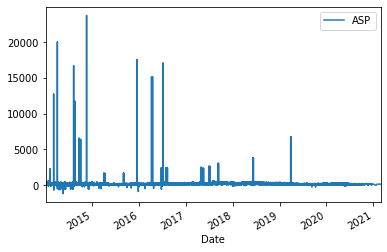

In [35]:
#To get a better picture if my model is stationary or not
#Or to identify whether or not trends or seasonal effects exists
series = df_commodity
series.plot()
plt.show()

In [38]:
#drop of null values for new df 

df_stationary = df_commodity.dropna()

df_stationary.head()

,ASP
Date,
2017-06-30,302.50
2015-01-15,174.07
2016-06-21,198.23
2014-08-01,227.14
2018-01-25,229.47


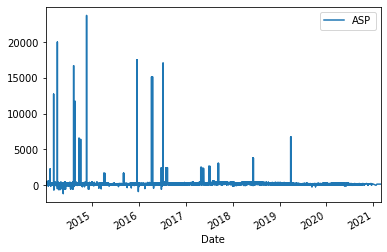

In [39]:
#Double check stationary status 

series2 = df_stationary
series2.plot()
plt.show()

In [40]:
#Summary stats using ADF 

result = adfuller(df_stationary['ASP'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -707.2179019046722
p-value: 0.0
Critical Values:
	1%: -3.4303630726275594
	5%: -2.861545777947517
	10%: -2.5667730753904006


In [41]:
# resample stationary data to account for variants or missing values potentially 

df_stationary2 = df_stationary['ASP'].resample('M').mean()

df_stationary2.head()


Date
2014-01-31    192.590145
2014-02-28    190.206806
2014-03-31    193.906745
2014-04-30    187.860060
2014-05-31    188.622050
Freq: M, Name: ASP, dtype: float64

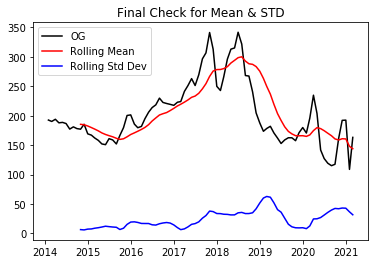

In [42]:
#Final check prior to training models to identify rolling mean, std with original stationary data
stationary_rolling_mean = df_stationary2.rolling(window = 10).mean()
stationary_rolling_std = df_stationary2.rolling(window = 10).std()
plt.plot(df_stationary2, color = 'black', label = 'OG')
plt.plot(stationary_rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(stationary_rolling_std, color = 'blue', label = 'Rolling Std Dev')
plt.legend(loc = 'best')
plt.title('Final Check for Mean & STD')
plt.show()

In [46]:
# Train data - all data up to the end of 2016
df_train1 = df_stationary2.loc[:'2016']

# Test data - 2017 + 2018
df_test = df_stationary2.loc['2017':'2018']

# df_test_18.head()

df_train1.head()

Date
2014-01-31    192.590145
2014-02-28    190.206806
2014-03-31    193.906745
2014-04-30    187.860060
2014-05-31    188.622050
Freq: M, Name: ASP, dtype: float64

(array([735234., 735354., 735477., 735599., 735719., 735842., 735964.,
        736085., 736208., 736330.]), <a list of 10 Text xticklabel objects>)

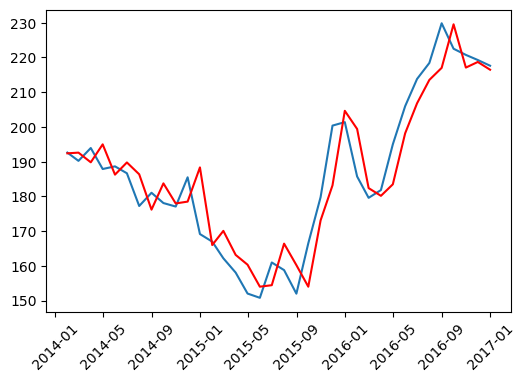

In [48]:
decomposition = seasonal_decompose(df_train1) 
model = ARIMA(df_train1, order=(1,0,1))
results = model.fit(disp=-1)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(df_stationary2.loc[:'2016'])
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([540, 552, 564]), <a list of 3 Text xticklabel objects>)

<Figure size 600x400 with 0 Axes>

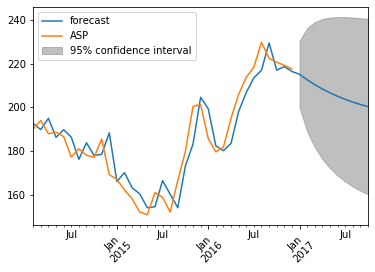

In [49]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_train1.iloc[0], index=df_train1.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,45)
plt.xticks(rotation=45)